**Imports and Workspace settings**

In [1]:
import pandas as pd
import numpy as np
import boto3
import io
import os
import json
import random
import PIL.Image as Image
import datetime
import plotly.express as px
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from utility.my_metrics import recall, precision, f1_score, MulticlassTruePositives
from utility.PerformanceVisualizationCallback import PerformanceVisualizationCallback
from utility.augmented_conv2d import augmented_conv2d

from s3fs.core import S3FileSystem
s3 = S3FileSystem()

import keras
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras import Sequential, layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, LayerNormalization, GlobalAveragePooling2D, multiply, Conv2D, Conv1D, MaxPooling2D, Reshape, TimeDistributed, Input, LSTM, GRU, concatenate
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import np_utils, plot_model

from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


In [2]:
tf.version.VERSION

'2.1.3'

**Deterministic randomness**

In [3]:
SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
# limit gpu usage for keras in tf 2.X
def set_gpu_memory_growth():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"Number of GPUs: {len(gpus)}")
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12288)])
                print(f"Enabled Memory Growth on {gpu.name}\n")
                print()
        except RuntimeError as e:
            print(e)

set_gpu_memory_growth()

Number of GPUs: 1
Enabled Memory Growth on /physical_device:GPU:0




**Configurations**

In [6]:
# 40 for all
# 20 only for prices/volumes
# 2 for bid ask only
FEATURES = 20
batch_size = 32
CHANNELS = 1
window_size = 100 # 64 or 32 length LSTM

**Define util functions**

In [7]:
price_indices = np.concatenate([np.array(range(2,40,4))[::-1], np.array(range(0,40,4))])
volume_indices = np.concatenate([np.array(range(3,40,4))[::-1], np.array(range(1,40,4))])
spatial_ordering = np.dstack((price_indices, volume_indices)).flatten()
bid_ask_indices = [2, 0]

def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1[:, volume_indices])

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX.reshape(dataX.shape + (1,)), dataY
#     return dataX, dataY

In [8]:
price_indices

array([38, 34, 30, 26, 22, 18, 14, 10,  6,  2,  0,  4,  8, 12, 16, 20, 24,
       28, 32, 36])

In [9]:
volume_indices

array([39, 35, 31, 27, 23, 19, 15, 11,  7,  3,  1,  5,  9, 13, 17, 21, 25,
       29, 33, 37])

In [10]:
spatial_ordering

array([38, 39, 34, 35, 30, 31, 26, 27, 22, 23, 18, 19, 14, 15, 10, 11,  6,
        7,  2,  3,  0,  1,  4,  5,  8,  9, 12, 13, 16, 17, 20, 21, 24, 25,
       28, 29, 32, 33, 36, 37])

In [11]:
# please change the data_path to your local path
data_path = '../FI-2010-lob-dataset/NoAuction/3.NoAuction_DecPre/'

dec_train = np.loadtxt(data_path + 'NoAuction_DecPre_Training/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_test1 = np.loadtxt(data_path + 'NoAuction_DecPre_Testing/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt(data_path + 'NoAuction_DecPre_Testing/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt(data_path + 'NoAuction_DecPre_Testing/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

In [141]:
# extract limit order book data from the FI-2010 dataset
train_lob = prepare_x(dec_train)
test_lob = prepare_x(dec_test)

# extract label from the FI-2010 dataset
train_label = get_label(dec_train)
test_label = get_label(dec_test)

# prepare training data. We feed past 100 observations into our algorithms and choose the prediction horizon. 
trainX_CNN, trainY_CNN = data_classification(train_lob, train_label, T=100)
trainY_CNN = trainY_CNN[:,1] - 1 # DeepLOB notation -> 0=10k, 1=20k, 2=30k, 3=50k, 4=100k
trainY_CNN = np_utils.to_categorical(trainY_CNN, 3)

# prepare test data.
testX_CNN, testY_CNN = data_classification(test_lob, test_label, T=100)
testY_CNN = testY_CNN[:,1] - 1
testY_CNN = np_utils.to_categorical(testY_CNN, 3)

In [142]:
dec_train.shape

(149, 254750)

In [143]:
train_lob.shape

(254750, 20)

In [144]:
test_label.T.shape

(5, 139587)

**calculate class weights of one hot encoded data**

In [145]:
y_integers = np.argmax(trainY_CNN, axis=1)
classWeight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
classWeight = dict(enumerate(classWeight))
print ('Class weights =' + str(json.dumps(classWeight)))

Class weights ={"0": 1.314904603309839, "1": 0.6745042883100509, "2": 1.3211465629053178}


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning:

Pass classes=[0 1 2], y=[0 0 1 ... 1 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



**Understand label distribution on training and test sets**

In [146]:
# fig = make_subplots(rows=1, cols=2, subplot_titles=("Training", "Testing"))

# fig.add_trace(
#     go.Histogram(x=tr_labels[:train_len].tolist(), histnorm='percent', marker_color='indianred'),
#     row=1, col=1
# )
# fig.add_trace(
#     go.Histogram(x=ts_labels[:test_len].tolist(), histnorm='percent', marker_color='indianred'),
#     row=1, col=2
# )
# fig.update_layout(
#     title="Movement label distribution",
#     width=600,
#     height=400,
#     showlegend=False,
#     bargap=0.1,
# )
# fig.show()

**Self attention block for LSTM layer output**

In [147]:
# https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

**Squeeze and Excite block for any CNN layers**

In [148]:
# For 2D channels
def SqueezeExcite2D(in_block, ch=32, ratio=4):
    x = GlobalAveragePooling2D()(in_block)
    x = Dense(ch//ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(x) # use_bias=False
    x = Dense(ch, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)
    return multiply([in_block, x])

def ConvBlock(_input):  # cleaner code
    x   = Conv1D(filters=10, kernel_size=3, padding='causal', use_bias=False,
                 kernel_initializer='lecun_normal')(_input)
    x   = BatchNormalization(scale=False)(x)
    x   = Activation('selu')(x)
    x   = AlphaDropout(0.1)(x)
    out = SqueezeExcite(x)    
    return out

# Only for 1D
def SqueezeExcite1D(_input, r=4):  # r == "reduction factor"; see paper
    filters = K.int_shape(_input)[-1]
    se = GlobalAveragePooling1D()(_input)
    se = Reshape((1, filters))(se)
    se = Dense(filters//r, activation='relu', use_bias=False, kernel_initializer='he_normal')(se)
    se = Dense(filters, activation='sigmoid', use_bias=False, kernel_initializer='he_normal')(se)
    return multiply([_input, se])

def inceptionModule(input_layer):
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(input_layer)
    convsecond_1 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(input_layer)
    convsecond_2 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(input_layer)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = tf.keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    return conv_reshape

# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit
# def resblock(x, kernelsize, filters):
#     fx1 = layers.Conv2D(filters, kernelsize, activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
#     fx1 = layers.BatchNormalization()(fx1)
#     fx2 = layers.Conv2D(filters, kernelsize, kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(fx1)
#     out = layers.Add()([x,fx2])
#     out = layers.ReLU()(out)
#     out = layers.BatchNormalization()(out)
#     return out

def resblock(x, kernelsize, filters):
    fx1 = layers.Conv2D(filters, kernelsize, kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
    fx1 = layers.Add()([x,fx1])
    fx1 = layers.ReLU()(fx1)
    fx1 = layers.BatchNormalization()(fx1)
    
    fx2 = layers.Conv2D(filters, kernelsize, kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(fx1)
    out = layers.Add()([x,fx2])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)
    return out

def make_residual_lstm_layers(input_layer, rnn_width, rnn_depth):
    """
    The intermediate LSTM layers return sequences, while the last returns a single element.
    The input is also a sequence. In order to match the shape of input and output of the LSTM
    to sum them we can do it only for all layers but the last.
    """
    x = input_layer
    for i in range(rnn_depth):
        return_sequences = i < rnn_depth - 1
        x_rnn = GRU(rnn_width, dropout=0.2, return_sequences=return_sequences, kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
        if return_sequences:
            # Intermediate layers return sequences, input is also a sequence.
            if i > 0 or input_layer.shape[-1] == rnn_width:
                x = layers.add([x, x_rnn])
            else:
                # Note that the input size and RNN output has to match, due to the sum operation.
                # If we want different rnn_width, we'd have to perform the sum from layer 2 on.
                x = x_rnn
        else:
            # Last layer does not return sequences, just the last element
            # so we select only the last element of the previous output.
            def slice_last(x):
                return x[..., -1, :]
            x = layers.add([layers.Lambda(slice_last)(x), x_rnn])
    return x

**Define models**

In [152]:
def create_cnn_lstm_model(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
   
    #  spatial distribution learning
    conv_first1 = Conv2D(32, (1, 2), activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(input_lmd)
    conv_first1 = SqueezeExcite2D(conv_first1, 32)
    conv_first1 = resblock(conv_first1, (2, 1), 32)
    conv_first1 = Dropout(0.2, noise_shape=(conv_first1.shape[0],1,1,conv_first1.shape[3]))(conv_first1)
    
    conv_first1 = Conv2D(32, (1, 4), activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(conv_first1)
    conv_first1 = SqueezeExcite2D(conv_first1, 32)
    conv_first1 = resblock(conv_first1, (4, 1), 32)
    conv_first1 = Dropout(0.2, noise_shape=(conv_first1.shape[0],1,1,conv_first1.shape[3]))(conv_first1)
   
    # strides=(1, 10),
    conv_first1 = Conv2D(32, (1, 10), activation='relu', strides=(1, 10), kernel_initializer='he_normal', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(conv_first1)
    conv_first1 = SqueezeExcite2D(conv_first1, 32)
    conv_first1 = resblock(conv_first1, (4, 1), 32)
    conv_first1 = Dropout(0.2, noise_shape=(conv_first1.shape[0],1,1,conv_first1.shape[3]))(conv_first1)
    
    conv_flat = Reshape((conv_first1.shape[1], conv_first1.shape[2]*conv_first1.shape[3]))(conv_first1)
    
    # build the last LSTM/ GRU layer
#     conv_lstm = LSTM(64, return_sequences=True, kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(conv_flat)
    # Residual LSTM: https://gist.github.com/bzamecnik/8ed16e361a0a6e80e2a4a259222f101e
    conv_lstm = make_residual_lstm_layers(conv_flat, 32, 3)

#     conv_lstm = attention()(conv_lstm)
    conv_lstm = BatchNormalization()(conv_lstm)
#     conv_lstm = Dropout(0.2)(conv_lstm)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = optimizers.Adam(lr=0.001, decay=0.001/40) 

#     model.load_weights('./weights/weights_no_images_28T.33-0.42.hdf5') # k=10, 32 all filters
    model.load_weights('./weights/weights_no_images_30T.40-0.61.hdf5')    # k=20
#     model.load_weights('./weights/weights_no_images_23T.31-0.48.hdf5')	# k=50
#     model.load_weights('./weights/weights_no_images_11T.42-0.42.hdf5')	# k=100

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy'),
                                                                            tf.keras.metrics.CategoricalCrossentropy('categorical_crossentropy'),
#                                                                             f1_score,
#                                                                             recall,
#                                                                             precision,
#                                                                             MulticlassTruePositives(),
                                                                            tf.keras.metrics.Precision(name='precision'),
                                                                            tf.keras.metrics.Recall(name='recall')])

    return model

# Call the above function with seed value
set_global_determinism(seed=SEED)

cnn_lstm_model = create_cnn_lstm_model(100, FEATURES, 64)
cnn_lstm_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100, 20, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 100, 20, 32)  96          input_9[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_24 (Gl (None, 32)           0           conv2d_72[0][0]                  
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 8)            256         global_average_pooling2d_24[0][0]
____________________________________________________________________________________________

**Training the model**

In [ ]:
checkpoint_filepath = './weights/weights_no_images_30T.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                            save_weights_only=True,
                                                            monitor='val_accuracy',
                                                            mode='max', verbose=1,
                                                            save_best_only=True)

# class reduce_lr(tf.keras.callbacks.Callback):
#     def on_epoch_begin(self, epoch, logs=None):
#         if epoch > 3:
#             lr = self.lr / 1.1
#             K.set_value(self.model.optimizer.lr, lr)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_crossentropy', factor=0.5, patience=2, min_lr=0.00005, verbose=1)

log_dir="tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

performance_viz_cbk = PerformanceVisualizationCallback(
                                       model=cnn_lstm_model,
                                       validation_data=(testX_CNN[25000:25500], testY_CNN[25000:25500]),
                                       image_dir=log_dir + '/perorfmance_charts')

csv_logger = tf.keras.callbacks.CSVLogger('training results/training.log')


tensorboard_cb= tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                               histogram_freq=1, # freq to compute activation and weight histograms
                                               write_images=False, # write model weights to visualize as image
                                               profile_batch = 2, # Profile the batch(es) to sample compute characteristics
                                               update_freq = 'epoch', # 'batch' or 'epoch' or integer (after each 100 batches)
#                                                embeddings_freq = 500, # freq at which embedding layers is visualized
                                              )
cnn_lstm_model._get_distribution_strategy = lambda: None

history = cnn_lstm_model.fit(trainX_CNN, trainY_CNN,
                            verbose = 2,
                            initial_epoch = 0,
                            epochs = 100,
                            shuffle=True,
                            batch_size=batch_size,
#                             class_weight=classWeight,
#                             workers = 4,
#                             use_multiprocessing = False,
#                             max_queue_size = 40,
                            validation_data = (testX_CNN, testY_CNN),
#                             callbacks=[reduce_lr, model_checkpoint_callback, csv_logger, performance_viz_cbk, tensorboard_cb])
                            callbacks=[reduce_lr, csv_logger, model_checkpoint_callback])

Train on 254651 samples, validate on 139488 samples
Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.74117, saving model to ./weights/weights_no_images_30T.01-0.66.hdf5
254651/254651 - 855s - loss: 0.8545 - accuracy: 0.6194 - categorical_crossentropy: 0.8545 - precision: 0.6930 - recall: 0.5021 - val_loss: 0.6561 - val_accuracy: 0.7412 - val_categorical_crossentropy: 0.6561 - val_precision: 0.7883 - val_recall: 0.6828
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.74117 to 0.74908, saving model to ./weights/weights_no_images_30T.02-0.64.hdf5
254651/254651 - 848s - loss: 0.7743 - accuracy: 0.6675 - categorical_crossentropy: 0.7743 - precision: 0.7241 - recall: 0.5832 - val_loss: 0.6365 - val_accuracy: 0.7491 - val_categorical_crossentropy: 0.6365 - val_precision: 0.7919 - val_recall: 0.6962
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.74908 to 0.75217, saving model to ./weights/weights_no_images_30T.03-0.63.hdf5
254651/254651 - 856s - loss: 0.7561 - accur

Epoch 23/100

Epoch 00023: ReduceLROnPlateau reducing learning rate to 5e-05.

Epoch 00023: val_accuracy did not improve from 0.76304
254651/254651 - 845s - loss: 0.7022 - accuracy: 0.6999 - categorical_crossentropy: 0.7022 - precision: 0.7496 - recall: 0.6297 - val_loss: 0.6063 - val_accuracy: 0.7629 - val_categorical_crossentropy: 0.6063 - val_precision: 0.8048 - val_recall: 0.7133
Epoch 24/100

Epoch 00024: val_accuracy did not improve from 0.76304
254651/254651 - 842s - loss: 0.7019 - accuracy: 0.7005 - categorical_crossentropy: 0.7019 - precision: 0.7497 - recall: 0.6295 - val_loss: 0.6071 - val_accuracy: 0.7626 - val_categorical_crossentropy: 0.6071 - val_precision: 0.8058 - val_recall: 0.7117
Epoch 25/100

Epoch 00025: val_accuracy did not improve from 0.76304
254651/254651 - 872s - loss: 0.7018 - accuracy: 0.7005 - categorical_crossentropy: 0.7018 - precision: 0.7497 - recall: 0.6310 - val_loss: 0.6067 - val_accuracy: 0.7630 - val_categorical_crossentropy: 0.6067 - val_precisio

In [150]:
# history = cnn_lstm_model.fit(x = train_generator,
#                             verbose = 2,
#                             initial_epoch = 0,
#                             epochs = 100,
#                             steps_per_epoch = len(train_generator),
# #                             class_weight=classWeight,
# #                             workers = 4,
# #                             use_multiprocessing = False,
# #                             max_queue_size = 40,
#                             validation_data = validation_generator,
#                             validation_steps = len(validation_generator),
# #                             callbacks=[reduce_lr, model_checkpoint_callback, csv_logger, performance_viz_cbk, tensorboard_cb])
#                             callbacks=[reduce_lr, csv_logger])

In [106]:
# history = cnn_lstm_model.fit(trainX_CNN, trainY_CNN,
#                             verbose = 2,
#                             initial_epoch = 25,
#                             epochs = 50,
#                             shuffle=True,
#                             batch_size=batch_size,
# #                             class_weight=classWeight,
# #                             workers = 4,
# #                             use_multiprocessing = False,
# #                             max_queue_size = 40,
#                             validation_data = (testX_CNN, testY_CNN),
#                             callbacks=[reduce_lr, model_checkpoint_callback, csv_logger, performance_viz_cbk, tensorboard_cb])

**Predict and evaluate the model**

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from itertools import cycle

target_names = ['Up','Stationary', 'Down']
labels = [0, 1, 2]

**Confusion matrix**

In [154]:
# # prepare time series generators
# train_gen = TimeseriesGenerator(trainX_CNN, trainY_CNN, length=window_size, batch_size=batch_size)
# validation_gen = TimeseriesGenerator(testX_CNN, testY_CNN, length=window_size, batch_size=batch_size)
# test_gen = TimeseriesGenerator(testX_CNN[50000:55000], testY_CNN[50000:55000], length=window_size, batch_size=1)

In [155]:
y_pred = cnn_lstm_model.predict(testX_CNN, batch_size=batch_size)
y_pred_class = np.argmax(y_pred, axis=1)

In [156]:
y_true = np.argmax(testY_CNN, axis=1)

In [157]:
cm = confusion_matrix(y_true, y_pred_class, normalize='pred')  # normalize='pred', 'true', 'all'

In [158]:
# Font increase for matplotlib -> confusion matrix display
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

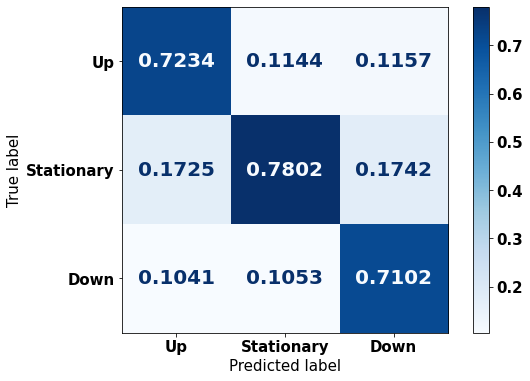

In [159]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Up','Stationary', 'Down'])
# plot and save confusion matrix
fig, ax = plt.subplots(figsize=(9,6))
cmd.plot(ax=ax, cmap=plt.cm.Blues, values_format='.4g')

**ROC AUC curve per class**


In [160]:
SMALL_SIZE = 9
MEDIUM_SIZE = 12
BIGGER_SIZE = 20
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

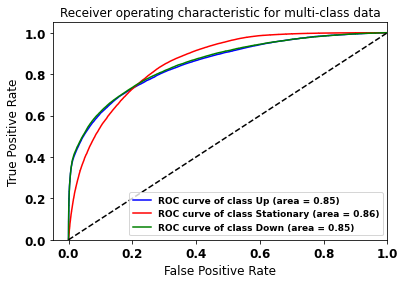

In [161]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY_CNN[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

**Evaluation report**

In [162]:
report = classification_report(y_true, y_pred_class, labels=labels, target_names=target_names, digits=4)
# df = pd.DataFrame(report).transpose()
# df
print(report)

              precision    recall  f1-score   support

          Up     0.7234    0.4955    0.5882     27425
  Stationary     0.7802    0.9267    0.8472     86588
        Down     0.7102    0.4979    0.5854     25475

    accuracy                         0.7636    139488
   macro avg     0.7379    0.6400    0.6736    139488
weighted avg     0.7563    0.7636    0.7484    139488



**Plot the model**

In [ ]:
# https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/

# !pip install pydot
from keras.utils.vis_utils import plot_model

plot_model(cnn_lob_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Save, Load the full model**

In [ ]:
cnn_lob_model.save("./weights/temp_model.h5")

In [ ]:
# model = keras.models.load_model('./weights/temp_model.h5')
# model.summary()

**Print variables in a python object**

In [ ]:
validation_generator.data.shape

In [ ]:
from pprint import pprint
pprint(vars(train_generator))

**Printing memory usage for variables (top10)**

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))